# $ e^{i\theta\sigma_{j}} = cos(\theta) I + i sin(\theta) \sigma_{j} $
https://math.stackexchange.com/questions/3236998/exponential-of-pauli-matrices/3237834

In [23]:
# import libraries
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    if n_qubit >= 2:
        for i in range(n_qubit-1):
            CNOT(circuit_layer, i, i+1)
        CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# amplitude encoding the features
def initial_state_amplitude(sample):
    qubit_num = int(math.ceil(np.log2(len(sample))))
    circuit_initial = Qubit(qubit_num)
    circuit_initial.amplitude[0:len(sample)] = sample/np.sqrt(np.sum(sample**2))
    return circuit_initial

# qubit encoding the features
def initial_state_qubit(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.cos(sample[0]/2), -np.sin(sample[0]/2)])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.cos(sample[i]/2), -np.sin(sample[i]/2)]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# dense qubit encoding the features
def initial_state_dense(sample):
    qubit_num = int(len(sample)/2)
    circuit_initial = Qubit(qubit_num)
    ampli_vec = np.array([np.cos(sample[0+qubit_num]/2)*np.cos(sample[0]/2) - 1j*np.sin(sample[0+qubit_num]/2)*np.sin(sample[0]/2),
                          -np.sin(sample[0+qubit_num]/2)*np.cos(sample[0]/2) - 1j*np.cos(sample[0+qubit_num]/2)*np.sin(sample[0]/2)])
    for i in range(1, qubit_num):
        ampli_vec = np.kron(ampli_vec, np.array([np.cos(sample[i+qubit_num]/2)*np.cos(sample[i]/2) - 1j*np.sin(sample[i+qubit_num]/2)*np.sin(sample[i]/2),
                                      -np.sin(sample[i+qubit_num]/2)*np.cos(sample[i]/2) - 1j*np.cos(sample[i+qubit_num]/2)*np.sin(sample[i]/2)]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params, encoded):
    if encoded == 'amplitude':
        circuit_model = initial_state_amplitude(sample)
    elif encoded == 'qubit':
        circuit_model = initial_state_qubit(sample)
    elif encoded == 'dense':
        circuit_model = initial_state_dense(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-10*x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    pred = sigmoid(expval_0-expval_1)
    return [pred, 1-pred]

# make a prediction for ex
def predict_ex(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    return [expval_0, expval_1]

# make a prediction
def predict_1(circuit):
    prob = predict_ex_1(circuit)
    return [sigmoid(prob[0]), sigmoid(prob[1])]

# make a prediction for ex
def predict_ex_1(circuit):
    prob = measure_one(circuit, 0)
    return 2*np.array([prob[0], prob[1]]) - 1

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels, encoded):
    preds = [predict(qnn_model(x, params, encoded)) for x in features]
    return square_loss(labels, preds)

# loss function of QNN
def cost_1(params, features, labels, encoded):
    preds = [predict_1(qnn_model(x, params, encoded)) for x in features]
    return square_loss(labels, preds)

# https://d2l.ai/chapter_optimization/adam.html?highlight=adam

def adam(X_true, y_true, params, v, s, shift, eta, drop_rate, beta1, beta2, eps, iter_num, encoded):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params, encoded)
                        circuit_1 = qnn_model(x, params_1, encoded)
                        circuit_2 = qnn_model(x, params_2, encoded)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    v = beta1 * v + (1 - beta1) * diff
    s = beta2 * s + (1 - beta2) * (diff**2)
    v_bias_corr = v / (1 - beta1 ** (iter_num+1))
    s_bias_corr = s / (1 - beta2 ** (iter_num+1))
    params -= eta * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    
    return params, v, s


def adam_1(X_true, y_true, params, v, s, shift, eta, drop_rate, beta1, beta2, eps, iter_num, encoded):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params, encoded)
                        circuit_1 = qnn_model(x, params_1, encoded)
                        circuit_2 = qnn_model(x, params_2, encoded)
                        ex_plus = predict_ex_1(circuit_1)
                        ex_subs = predict_ex_1(circuit_2)
                        pred = predict_1(circuit)
                        diff_loss = (-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*(ex_plus[y] - ex_subs[y])/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    v = beta1 * v + (1 - beta1) * diff
    s = beta2 * s + (1 - beta2) * (diff**2)
    v_bias_corr = v / (1 - beta1 ** (iter_num+1))
    s_bias_corr = s / (1 - beta2 ** (iter_num+1))
    params -= eta * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    
    return params, v, s

In [2]:
def qnn_training(X_true, y_true, max_ieration, n_layer=1, shift=np.pi/20, eta=0.1, drop_rate=0.1, choice='grad', encoded='amplitude'):
    params = np.zeros((n_layer, int(math.ceil(np.log2(len(X_true[0])))), 2, ))
    # params = np.zeros((n_layer, len(X_train[0]), 2,))
    cost_train = []
    if choice == 'grad':
        for k in range(max_ieration):
            params = grad(X_true, y_true, params, shift, eta, drop_rate, encoded)
            cost_train.append(cost(params, X_true, y_true))
    elif choice == 'adagrad':
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, s = adagrad(X_true, y_true, params, s, shift, eta, drop_rate, 1e-6, encoded)
            cost_train.append(cost(params, X_true, y_true))
    elif choice == 'adam':
        v = np.zeros(params.shape)
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, v, s = adam(X_true, y_true, params, v, s, shift, eta, drop_rate, 0.9, 0.99, 1e-6, k, encoded)
            cost_train.append(cost(params, X_true, y_true))
    return params, np.array(cost_train)

In [3]:
#source: https://www.kaggle.com/ronitf/heart-disease-uci
dataset = pd.read_csv('heart.csv')
dataset = dataset[['age', 'chol', 'target']]

X_amplitude = dataset.iloc[:, 0:-1].values

X_qubit = dataset.iloc[:, 0:-1].values
X_qubit = (X_qubit - X_qubit.min())/(X_qubit.max() - X_qubit.min())
X_qubit = X_qubit*0.9999*np.pi

y = dataset.iloc[:, -1].values

# Test 1

In [4]:
X_amplitude[0]

array([ 63, 233], dtype=int64)

In [5]:
circuit = initial_state_amplitude(X_amplitude[0])
circuit.print_state()

'(0.26101337594654966+0j)|0> + (0.9653351840562868+0j)|1>'

In [6]:
circuit.probabilities()

array([0.06812798, 0.93187202])

In [7]:
circuit = initial_state_qubit(X_qubit[0])
circuit.print_state()

'0.8218461595147674|00> + -0.560926587300009|01> + -0.0823071963076553|10> + 0.056176322296551916|11>'

In [8]:
circuit.probabilities()

array([0.67543111, 0.31463864, 0.00677447, 0.00315578])

In [9]:
circuit = initial_state_dense(X_qubit[0])
circuit.print_state()

'(0.8218461595147674-0.056176322296551916j)|0> + (-0.560926587300009-0.0823071963076553j)|1>'

In [10]:
circuit.probabilities()

array([0.67858689, 0.32141311])

# Test 2

In [11]:
n_layer = 2
params = np.zeros((n_layer, len(X_qubit[0]), 2,))

In [12]:
params

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [13]:
qnn_model(X_qubit[0], params, encoded = 'qubit').print_state()

'(0.8218461595147674+0j)|00> + (0.056176322296551916+0j)|01> + (-0.560926587300009+0j)|10> + (-0.0823071963076553+0j)|11>'

In [14]:
n_layer = 2
params = np.zeros((n_layer, int(math.ceil(np.log2(len(X_qubit[0])))), 2,))
params

array([[[0., 0.]],

       [[0., 0.]]])

In [15]:
qnn_model(X_qubit[0], params, encoded = 'dense').print_state()

'(0.8218461595147674-0.056176322296551916j)|0> + (-0.560926587300009-0.0823071963076553j)|1>'

In [16]:
n_layer = 2
params = np.zeros((n_layer, int(math.ceil(np.log2(len(X_amplitude[0])))), 2,))
params

array([[[0., 0.]],

       [[0., 0.]]])

In [17]:
qnn_model(X_amplitude[0], params, encoded = 'amplitude').print_state()

'(0.26101337594654966+0j)|0> + (0.9653351840562868+0j)|1>'

# Run

In [18]:
#source: https://www.kaggle.com/ronitf/heart-disease-uci
dataset = pd.read_csv('heart.csv')
dataset = dataset[['age', 'chol', 'target']]

X_amplitude = dataset.iloc[:, 0:-1].values

X_qubit = dataset.iloc[:, 0:-1].values
X_qubit = (X_qubit - X_qubit.min())/(X_qubit.max() - X_qubit.min())
X_qubit = X_qubit*0.9999*np.pi

y = dataset.iloc[:, -1].values

In [19]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_qubit, y, test_size = 0.2, random_state = 0)

In [20]:
label_train = y_train
label_test = y_test


params = np.zeros((5, len(X_train[0]), 2,))
v = np.zeros(params.shape)
s = np.zeros(params.shape)

costs_train_qubit = []
costs_test_qubit = []
accuracy_train_qubit = []
accuracy_test_qubit = []

start = time.time()
for i in range(100):
    params, v, s = adam(X_train, y_train, params, v, s, 
                        shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.99, eps=1e-6, iter_num=i, encoded='qubit')

    pred_train = [predict(qnn_model(x, params, encoded='qubit')) for x in X_train]
    pred_train = np.argmax(pred_train, axis=1)

    pred_test = [predict(qnn_model(x, params, encoded='qubit')) for x in X_test]
    pred_test = np.argmax(pred_test, axis=1)

    costs_train_qubit.append(cost(params, X_train, y_train, encoded='qubit'))
    costs_test_qubit.append(cost(params, X_test, y_test, encoded='qubit'))
    accuracy_train_qubit.append(accuracy_score(label_train, pred_train))
    accuracy_test_qubit.append(accuracy_score(label_test, pred_test))
    
    #     if costs_train[-1] >= costs_train[-2]:
    #         break
print(time.time()-start)

839.5441436767578


In [24]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_amplitude, y, test_size = 0.2, random_state = 0)

In [25]:

label_train = y_train
label_test = y_test


params = np.zeros((5, int(math.ceil(np.log2(len(X_amplitude[0])))), 2,))
v = np.zeros(params.shape)
s = np.zeros(params.shape)

costs_train_amplitude = []
costs_test_amplitude = []
accuracy_train_amplitude = []
accuracy_test_amplitude = []

start = time.time()
for i in range(100):
    params, v, s = adam_1(X_train, y_train, params, v, s, 
                        shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.99, eps=1e-6, iter_num=i, encoded='amplitude')

    pred_train = [predict_1(qnn_model(x, params, encoded='amplitude')) for x in X_train]
    pred_train = np.argmax(pred_train, axis=1)

    pred_test = [predict_1(qnn_model(x, params, encoded='amplitude')) for x in X_test]
    pred_test = np.argmax(pred_test, axis=1)

    costs_train_amplitude.append(cost_1(params, X_train, y_train, encoded='amplitude'))
    costs_test_amplitude.append(cost_1(params, X_test, y_test, encoded='amplitude'))
    accuracy_train_amplitude.append(accuracy_score(label_train, pred_train))
    accuracy_test_amplitude.append(accuracy_score(label_test, pred_test))
    
    #     if costs_train[-1] >= costs_train[-2]:
    #         break
print(time.time()-start)

129.01526260375977


In [28]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_qubit, y, test_size = 0.2, random_state = 0)

In [29]:
label_train = y_train
label_test = y_test


params = np.zeros((5, int(math.ceil(np.log2(len(X_qubit[0])))), 2,))
v = np.zeros(params.shape)
s = np.zeros(params.shape)

costs_train_dense = []
costs_test_dense = []
accuracy_train_dense = []
accuracy_test_dense = []

start = time.time()
for i in range(100):
    params, v, s = adam_1(X_train, y_train, params, v, s, 
                        shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.99, eps=1e-6, iter_num=i, encoded='dense')

    pred_train = [predict_1(qnn_model(x, params, encoded='dense')) for x in X_train]
    pred_train = np.argmax(pred_train, axis=1)

    pred_test = [predict_1(qnn_model(x, params, encoded='dense')) for x in X_test]
    pred_test = np.argmax(pred_test, axis=1)

    costs_train_dense.append(cost_1(params, X_train, y_train, encoded='dense'))
    costs_test_dense.append(cost_1(params, X_test, y_test, encoded='dense'))
    accuracy_train_dense.append(accuracy_score(label_train, pred_train))
    accuracy_test_dense.append(accuracy_score(label_test, pred_test))
    
    #     if costs_train[-1] >= costs_train[-2]:
    #         break
print(time.time()-start)

134.55431985855103


In [59]:
SIZE = 34*2
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


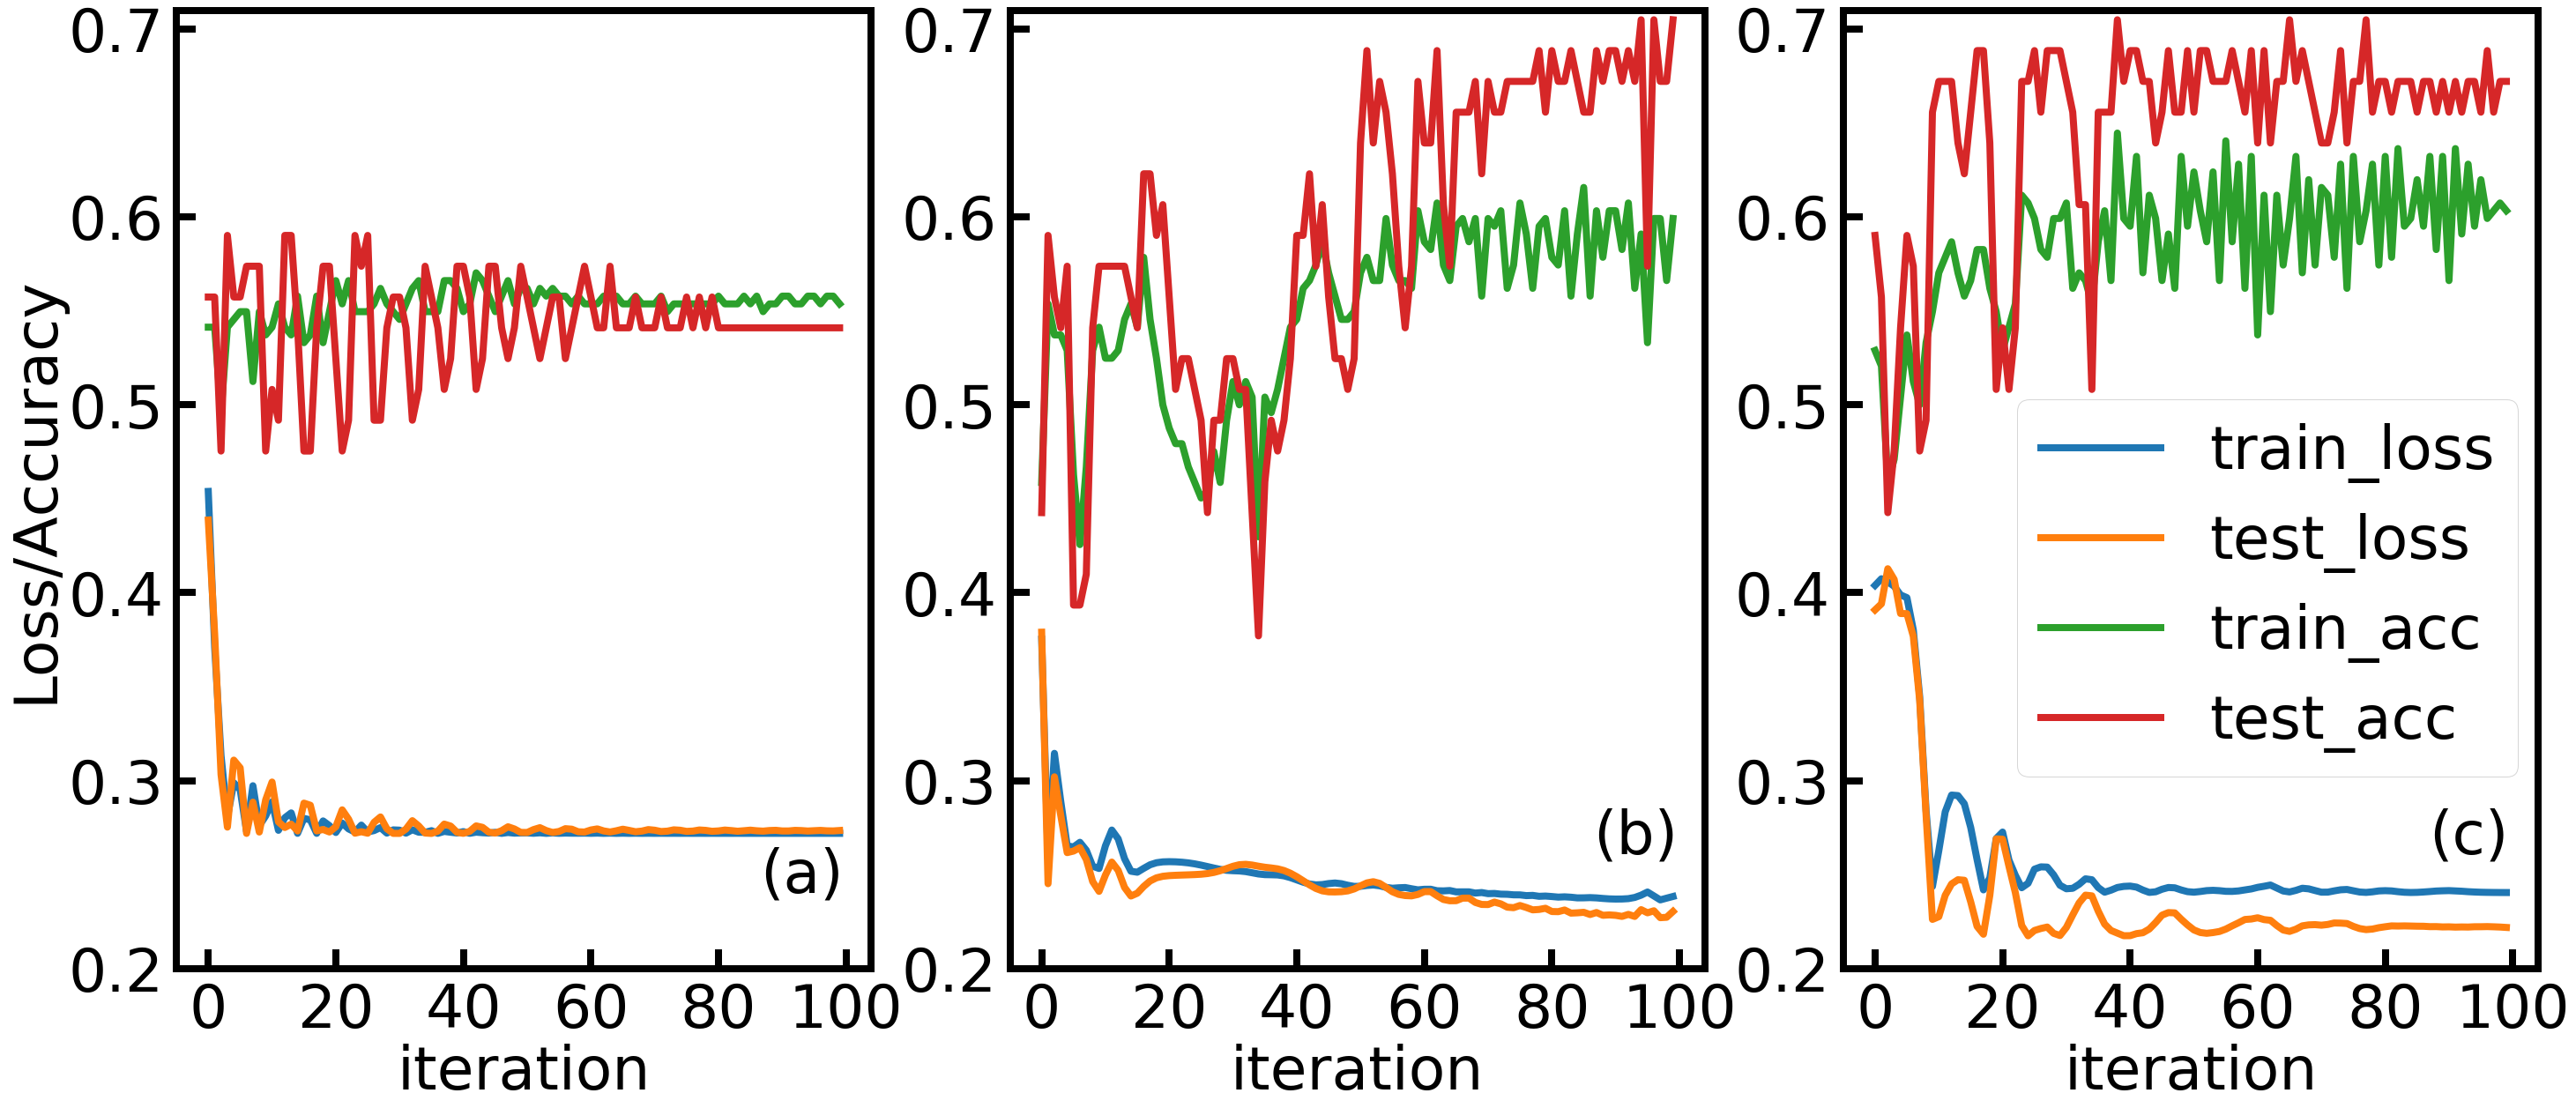

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(60*0.8, 20), linewidth=8)

axes[0].plot(range(len(costs_train_amplitude)), costs_train_amplitude, linewidth=8, label='train_loss')
axes[0].plot(range(len(costs_test_amplitude)), costs_test_amplitude, linewidth=8, label='test_loss')
axes[0].plot(range(len(accuracy_train_amplitude)), accuracy_train_amplitude, linewidth=8, label='train_acc')
axes[0].plot(range(len(accuracy_test_amplitude)), accuracy_test_amplitude, linewidth=8, label='test_acc')
axes[0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0].text(.9,0.08,'(a)',
        horizontalalignment='center',
        transform=axes[0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(8)
    axes[0].spines[axis].set_zorder(0)
# axes[0].yscale('log')
axes[0].set_xlabel('iteration')
# axes[0].legend(loc=(0.25, 0.2))
axes[0].set_ylabel('Loss/Accuracy')
axes[0].set_ylim(0.2, 0.71)
axes[0].set_xticks(np.arange(0, 120, 20))
axes[0].set_yticks(np.arange(0.2, .71, .1))

axes[1].plot(range(len(costs_train_qubit)), costs_train_qubit, linewidth=8, label='train_loss')
axes[1].plot(range(len(costs_test_qubit)), costs_test_qubit, linewidth=8, label='test_loss')
axes[1].plot(range(len(accuracy_train_qubit)), accuracy_train_qubit, linewidth=8, label='train_acc')
axes[1].plot(range(len(accuracy_test_qubit)), accuracy_test_qubit, linewidth=8, label='test_acc')
axes[1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1].text(.9,0.12,'(b)',
        horizontalalignment='center',
        transform=axes[1].transAxes)
for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(8)
    axes[1].spines[axis].set_zorder(0)
# axes[1].yscale('log')
axes[1].set_xlabel('iteration')
# axes[1].legend(loc=(0.25, 0.2))
# axes[1].set_ylabel('Loss/Accuracy')
axes[1].set_ylim(0.2, 0.71)
axes[1].set_xticks(np.arange(0, 120, 20))
axes[1].set_yticks(np.arange(0.2, .71, .1))


axes[2].plot(range(len(costs_train_dense)), costs_train_dense, linewidth=8, label='train_loss')
axes[2].plot(range(len(costs_test_amplitude)), costs_test_dense, linewidth=8, label='test_loss')
axes[2].plot(range(len(accuracy_train_dense)), accuracy_train_dense, linewidth=8, label='train_acc')
axes[2].plot(range(len(accuracy_test_dense)), accuracy_test_dense, linewidth=8, label='test_acc')
axes[2].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[2].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[2].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[2].text(.9,0.12,'(c)',
        horizontalalignment='center',
        transform=axes[2].transAxes)
for axis in ['top','bottom','left','right']:
    axes[2].spines[axis].set_linewidth(8)
    axes[2].spines[axis].set_zorder(0)
# axes[2].yscale('log')
axes[2].set_xlabel('iteration')
axes[2].legend(loc=(0.25, 0.2))
# axes[2].set_ylabel('Loss/Accuracy'))
axes[2].set_ylim(0.2, 0.71)
axes[2].set_xticks(np.arange(0, 120, 20))
axes[2].set_yticks(np.arange(0.2, .71, .1))

plt.savefig('qnn_encoding.png')
plt.savefig('qnn_encoding.eps', format='eps')

# Plot 

In [29]:
SIZE = 34*2
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

In [30]:
data_nn = pd.read_csv('data_layer_nn.csv', index_col=0).values
data_qnn = pd.read_csv('data_layer_qnn.csv', index_col=0).values
data_penny = pd.read_csv('data_layer_penny.csv', index_col=0).values

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


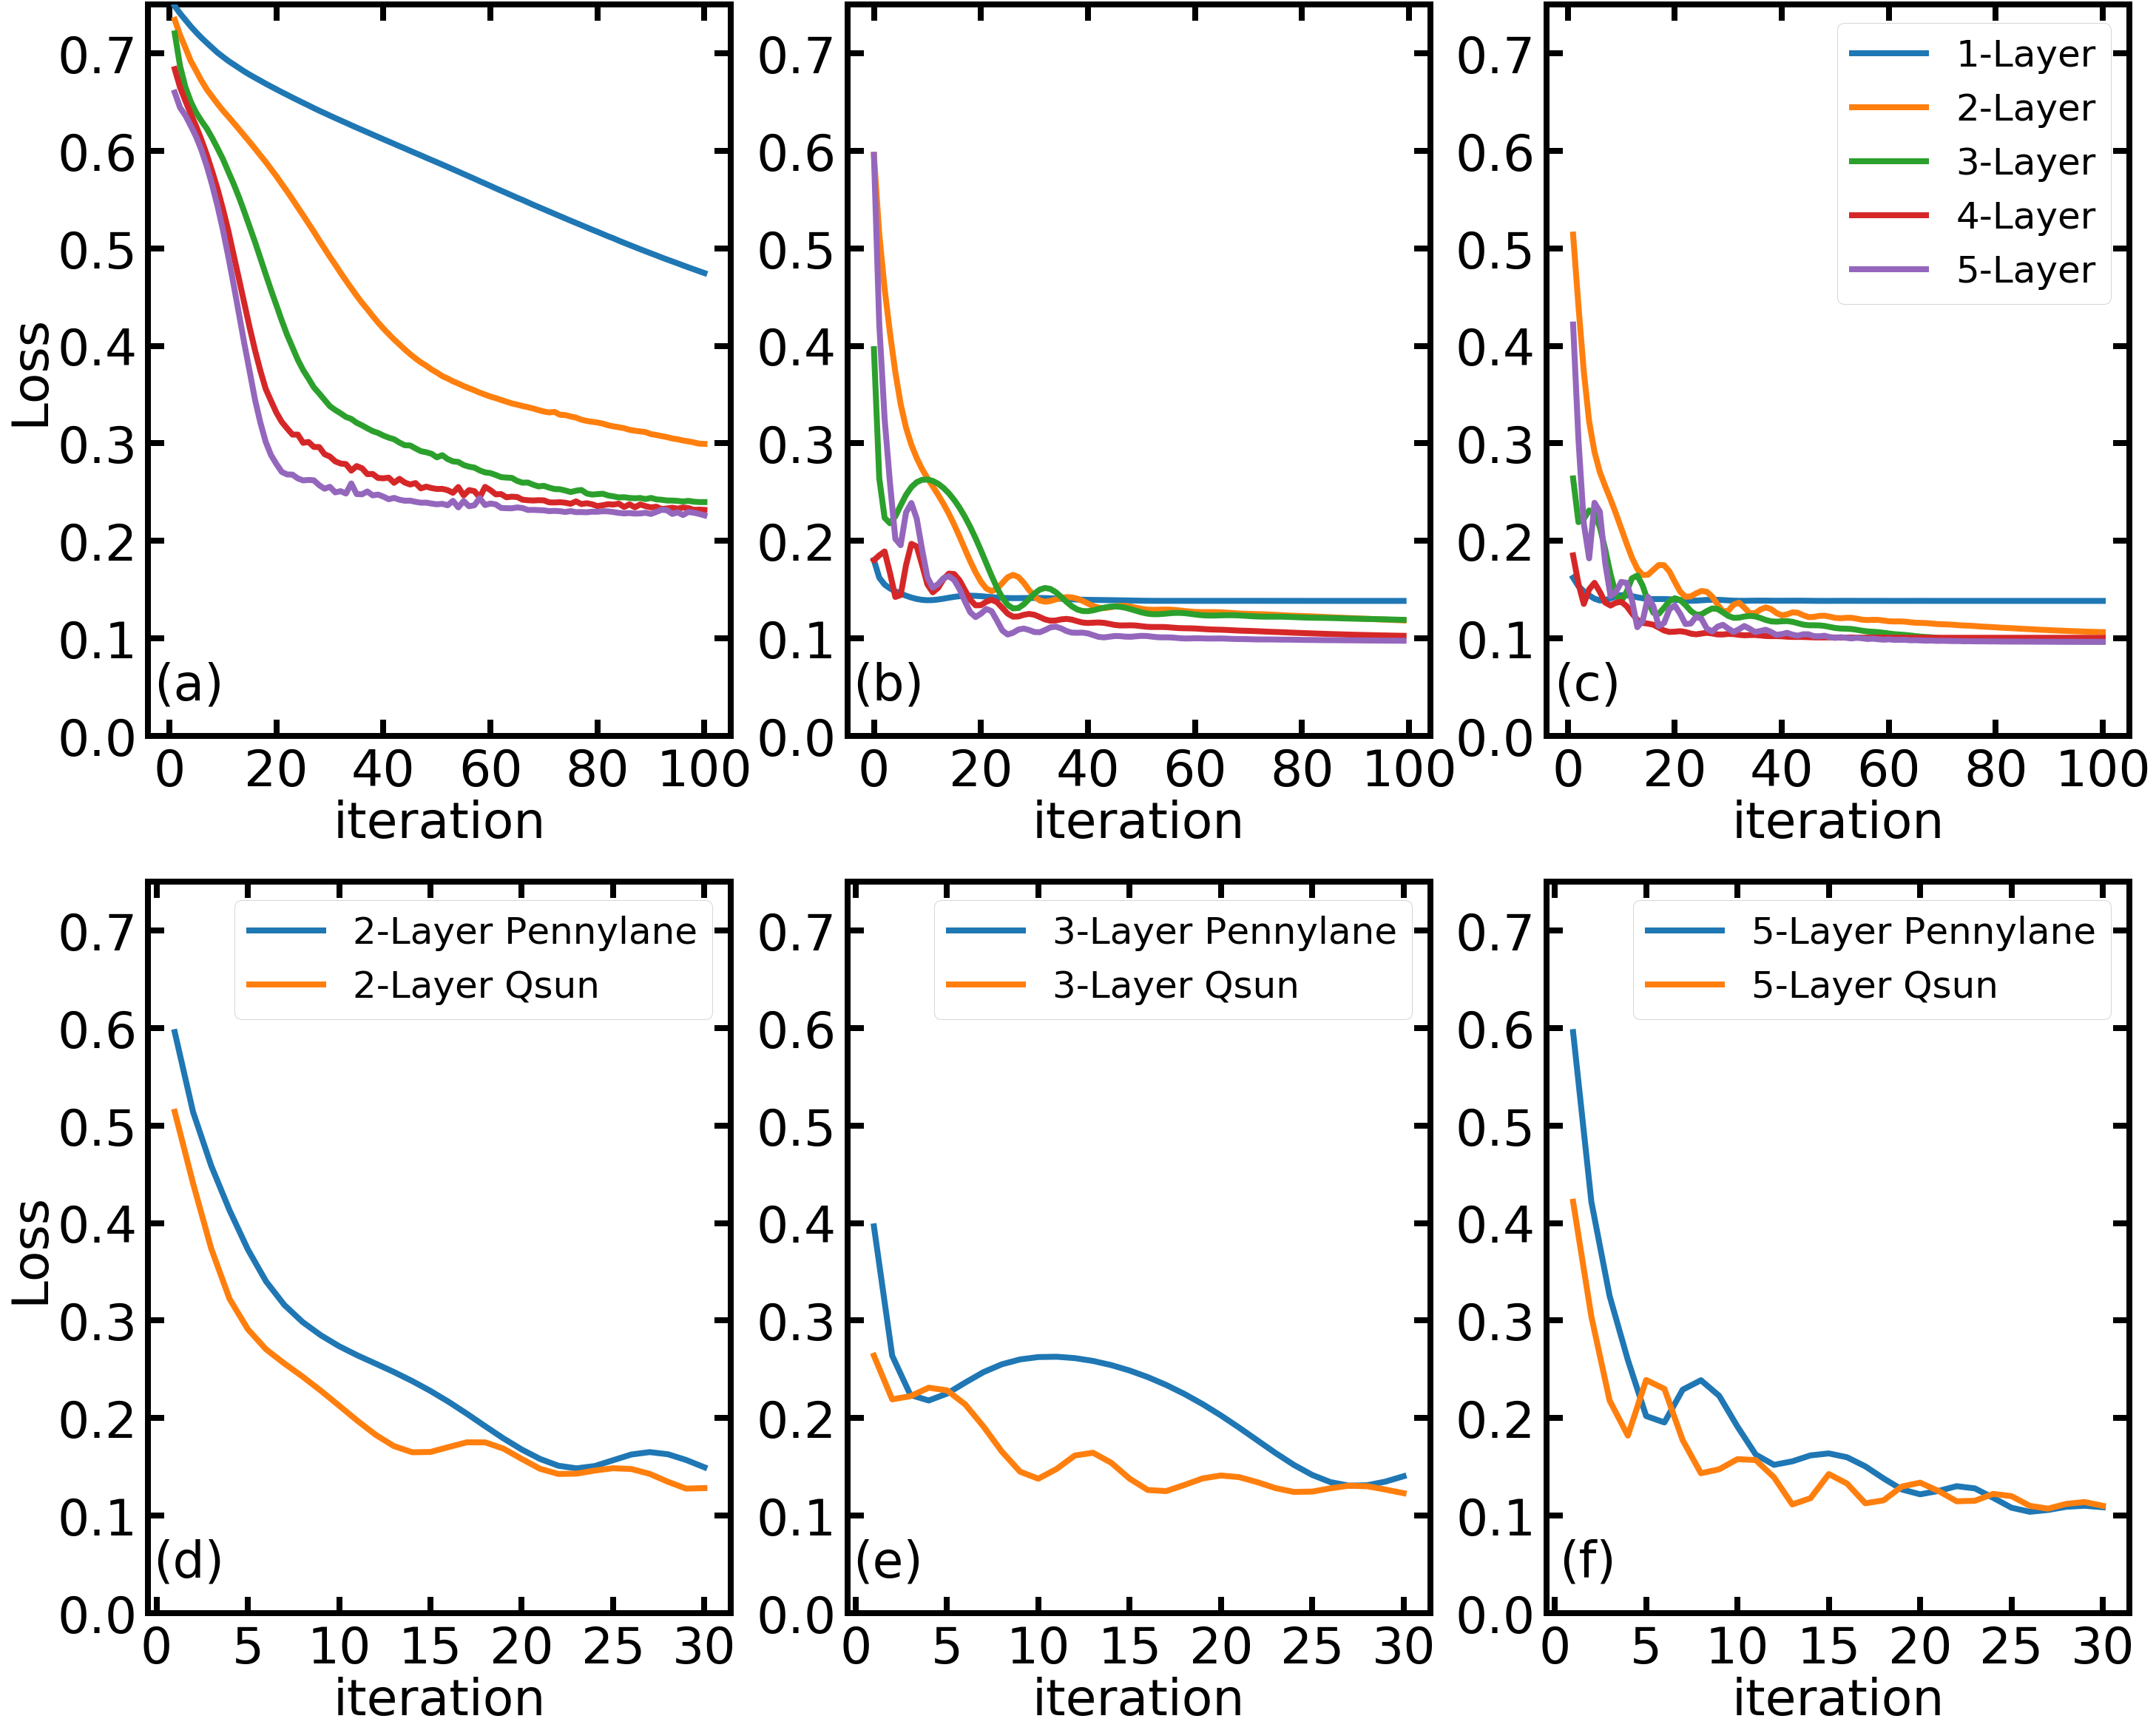

In [66]:
# fig, axes = plt.subplots(1, 2, figsize=(40,13.33))
# fig.suptitle('Loss function')
fig, axes = plt.subplots(2, 3, figsize=(60*0.8, 40), linewidth=8)

costs_train_nn = data_nn[:, :]
costs_train_qnn = data_qnn[:, :]
costs_train_penny = data_penny[:, :]

# NN
for l in range(1, 6):
    axes[0][0].plot(range(1, len(costs_train_nn[l-1])+1), costs_train_nn[l-1], linewidth=8, label=str(l)+'-Layer')
axes[0][0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0][0].tick_params(top=True, right=True)
axes[0][0].set_xlabel('iteration')
axes[0][0].set_ylabel('Loss')
axes[0][0].text(.07,0.05,'(a)',
        horizontalalignment='center',
        transform=axes[0][0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0][0].spines[axis].set_linewidth(8)
    axes[0][0].spines[axis].set_zorder(0)
axes[0][0].set_ylim(0, 0.75)
axes[0][0].set_xticks(np.arange(0, 120, 20))
axes[0][0].set_yticks(np.arange(0, .8, .1))

# Penylane
for l in range(1, 6):
    axes[0][1].plot(range(len(costs_train_penny[l-1])), costs_train_penny[l-1], linewidth=8, label=str(l)+'-Layer')
axes[0][1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0][1].tick_params(top=True, right=True)
axes[0][1].set_xlabel('iteration')
# axes[0][1].set_ylabel('Loss')
axes[0][1].text(.07,0.05,'(b)',
        horizontalalignment='center',
        transform=axes[0][1].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0][1].spines[axis].set_linewidth(8)
    axes[0][1].spines[axis].set_zorder(0)
axes[0][1].set_ylim(0, 0.75)
axes[0][1].set_xticks(np.arange(0, 120, 20))
axes[0][1].set_yticks(np.arange(0, .8, .1))

# QNN
for l in range(1, 6):
    axes[0][2].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=8, label=str(l)+'-Layer')
axes[0][2].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][2].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0][2].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0][2].tick_params(top=True, right=True)
axes[0][2].set_xlabel('iteration')
# axes[0][2].set_ylabel('Loss')
axes[0][2].text(.07,0.05,'(c)',
        horizontalalignment='center',
        transform=axes[0][2].transAxes)
axes[0][2].legend(loc='upper right', fontsize=50)
for axis in ['top','bottom','left','right']:
    axes[0][2].spines[axis].set_linewidth(8)
    axes[0][2].spines[axis].set_zorder(0)
axes[0][2].set_ylim(0, 0.75)
axes[0][2].set_xticks(np.arange(0, 120, 20))
axes[0][2].set_yticks(np.arange(0, .8, .1))


costs_train_nn = data_nn[:, :30]
costs_train_qnn = data_qnn[:, :30]
costs_train_penny = data_penny[:, :30]

# NN
l = 2
axes[1][0].plot(range(1, len(costs_train_penny[l-1])+1), costs_train_penny[l-1], linewidth=8, label=str(l)+'-Layer Pennylane')
axes[1][0].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=8, label=str(l)+'-Layer Qsun')
axes[1][0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1][0].tick_params(top=True, right=True)
axes[1][0].set_xlabel('iteration')
axes[1][0].set_ylabel('Loss')
axes[1][0].text(.07,0.05,'(d)',
        horizontalalignment='center',
        transform=axes[1][0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[1][0].spines[axis].set_linewidth(8)
    axes[1][0].spines[axis].set_zorder(0)
axes[1][0].legend(loc='upper right', fontsize=50)
axes[1][0].set_ylim(0, 0.75)
axes[1][0].set_xticks(np.arange(0, 31, 5))
axes[1][0].set_yticks(np.arange(0, .8, .1))

# Penylane
l = 3
axes[1][1].plot(range(1, len(costs_train_penny[l-1])+1), costs_train_penny[l-1], linewidth=8, label=str(l)+'-Layer Pennylane')
axes[1][1].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=8, label=str(l)+'-Layer Qsun')
axes[1][1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1][1].tick_params(top=True, right=True)
axes[1][1].set_xlabel('iteration')
# axes[1][1].set_ylabel('Loss')
axes[1][1].text(.07,0.05,'(e)',
        horizontalalignment='center',
        transform=axes[1][1].transAxes)
for axis in ['top','bottom','left','right']:
    axes[1][1].spines[axis].set_linewidth(8)
    axes[1][1].spines[axis].set_zorder(0)
axes[1][1].legend(loc='upper right', fontsize=50)
axes[1][1].set_ylim(0, 0.75)
axes[1][1].set_xticks(np.arange(0, 31, 5))
axes[1][1].set_yticks(np.arange(0, .8, .1))

# QNN
l = 5
axes[1][2].plot(range(1, len(costs_train_penny[l-1])+1), costs_train_penny[l-1], linewidth=8, label=str(l)+'-Layer Pennylane')
axes[1][2].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=8, label=str(l)+'-Layer Qsun')
axes[1][2].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][2].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1][2].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1][2].tick_params(top=True, right=True)
axes[1][2].set_xlabel('iteration')
# axes[1][2].set_ylabel('Loss')
axes[1][2].text(.07,0.05,'(f)',
        horizontalalignment='center',
        transform=axes[1][2].transAxes)
axes[1][2].legend(loc='upper right', fontsize=50)
for axis in ['top','bottom','left','right']:
    axes[1][2].spines[axis].set_linewidth(8)
    axes[1][2].spines[axis].set_zorder(0)
axes[1][2].set_ylim(0, 0.75)
axes[1][2].set_xticks(np.arange(0, 31, 5))
axes[1][2].set_yticks(np.arange(0, .8, .1))

plt.savefig('layer_train_complete.png')
plt.savefig('layer_train_complete.eps', format='eps')

In [78]:
costs_train_nn = data_nn[:, :]
costs_train_qnn = data_qnn[:, :]
costs_train_penny = data_penny[:, :]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


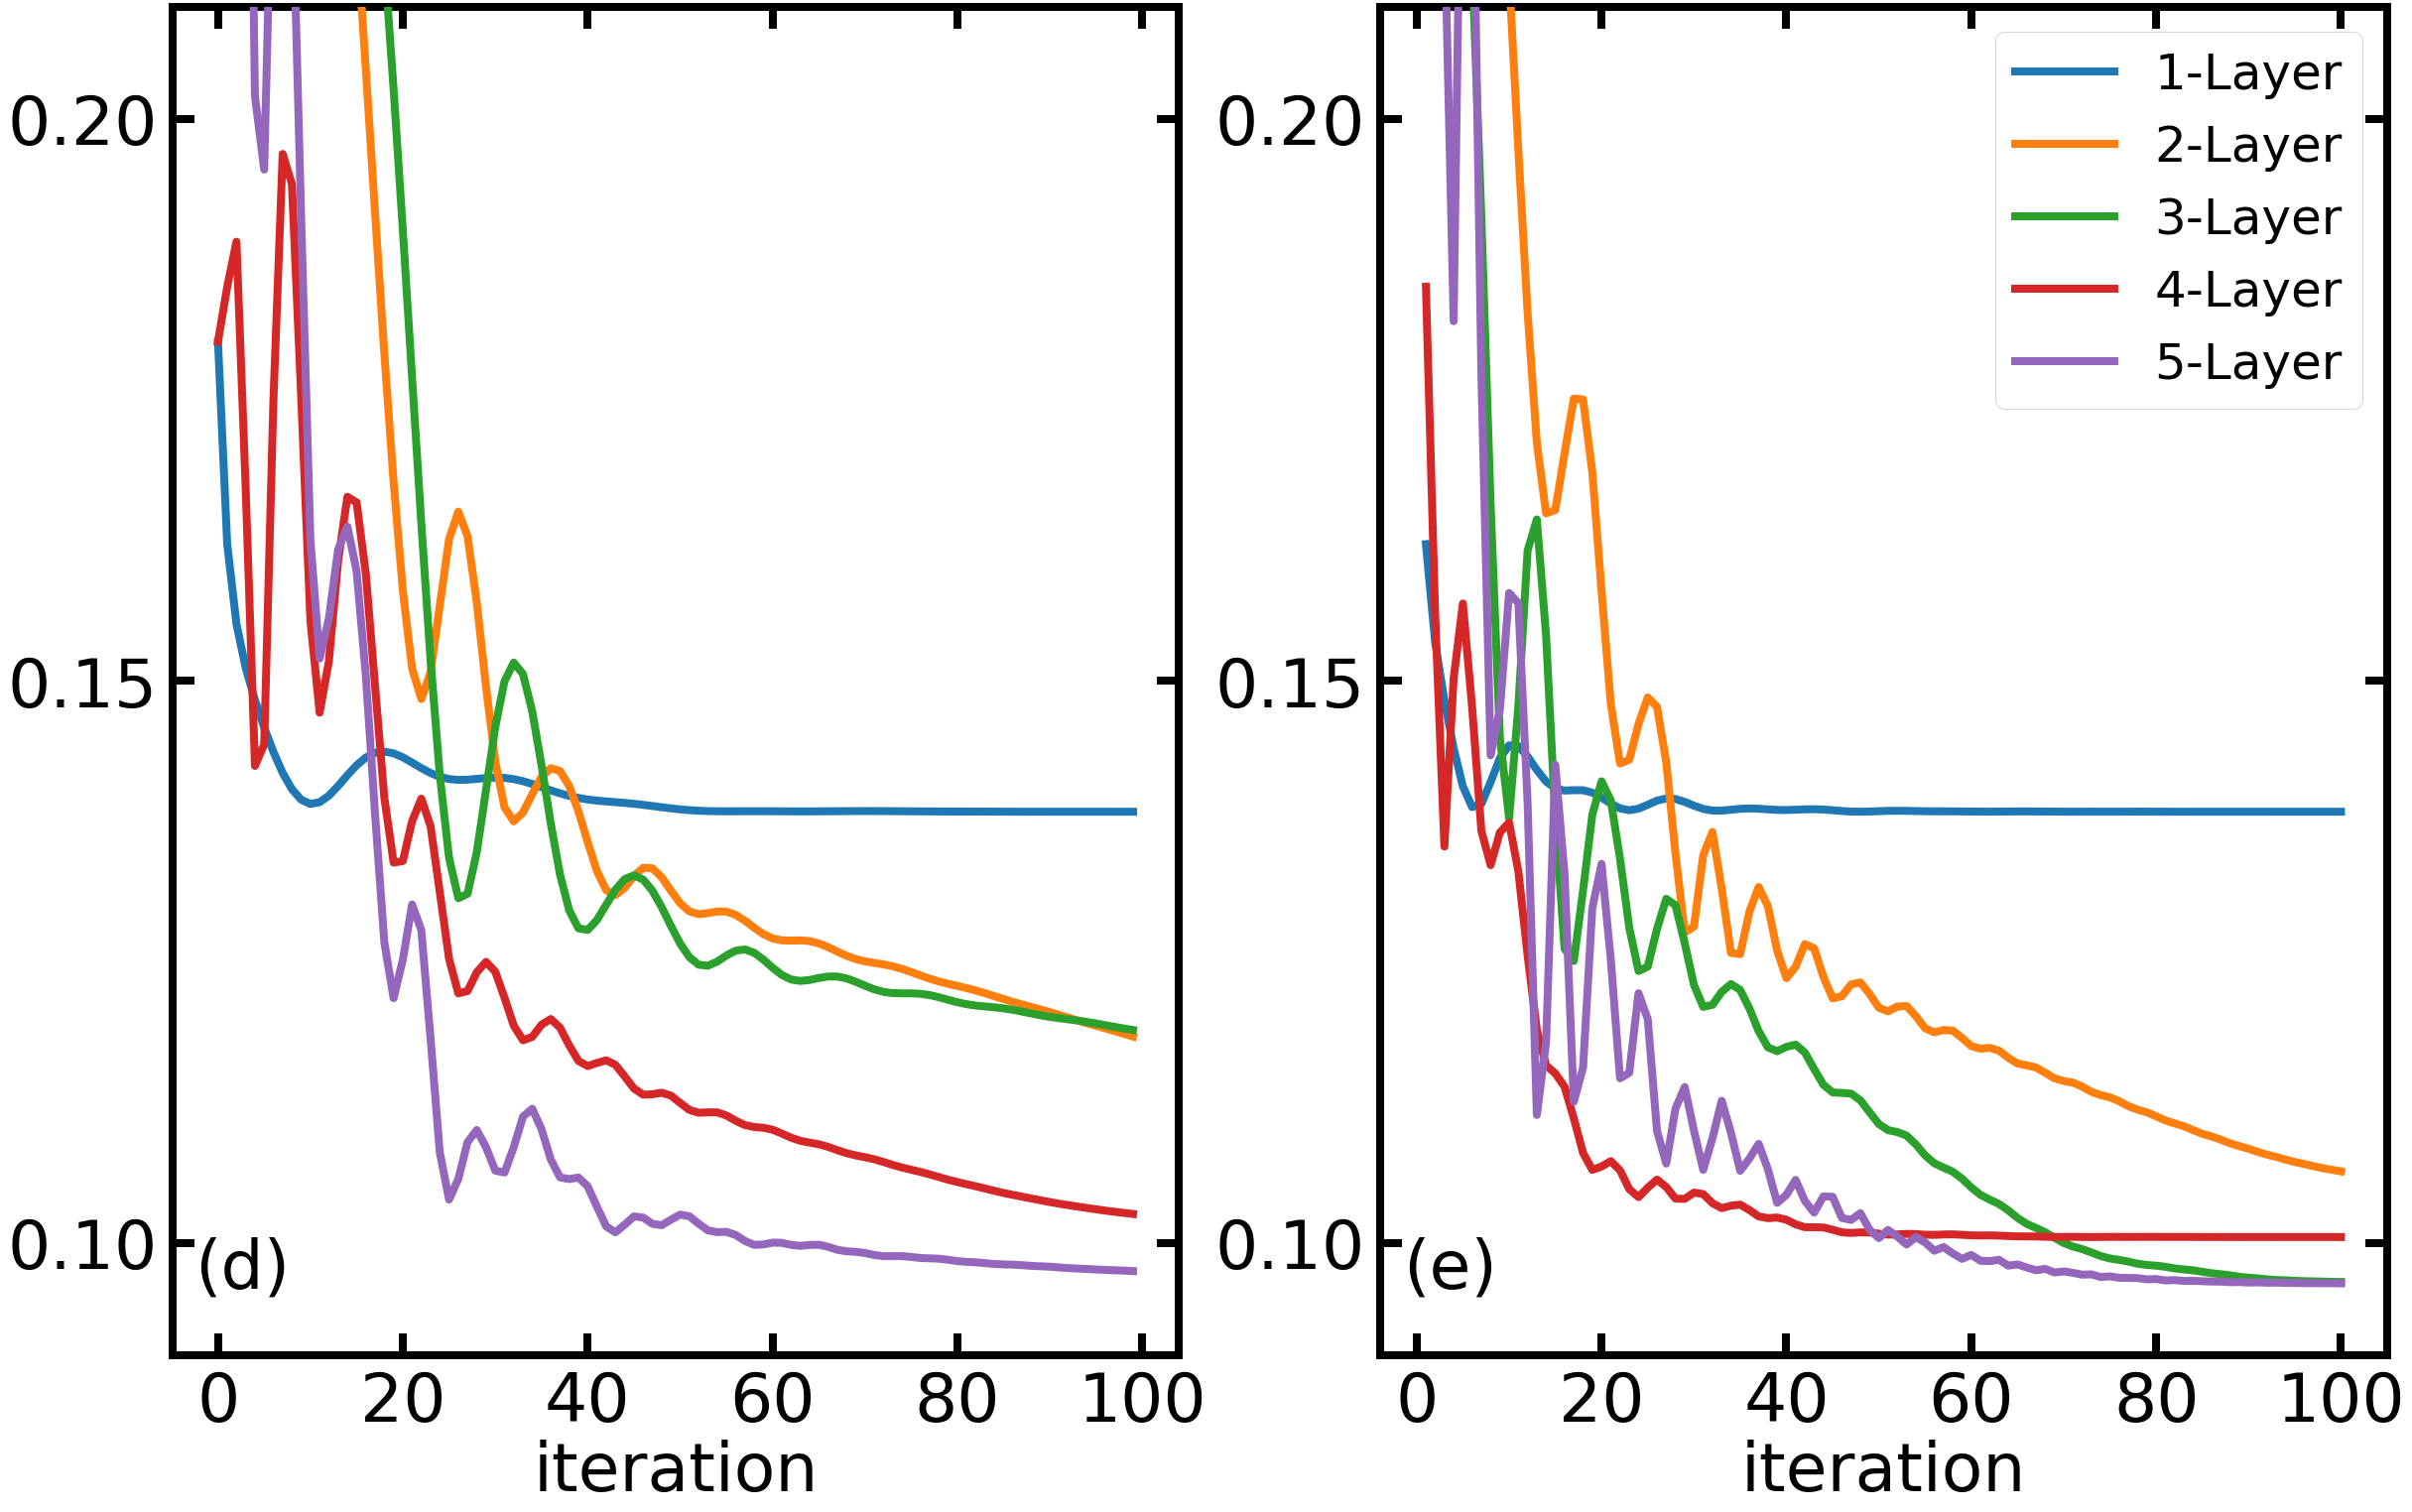

In [99]:
# fig, axes = plt.subplots(1, 2, figsize=(40,13.33))
# fig.suptitle('Loss function')
fig, axes = plt.subplots(1, 2, figsize=(50*0.8, 25), linewidth=8)

# Penylane
for l in range(1, 6):
    axes[0].plot(range(len(costs_train_penny[l-1])), costs_train_penny[l-1], linewidth=8, label=str(l)+'-Layer')
axes[0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0].tick_params(top=True, right=True)
axes[0].set_xlabel('iteration')
# axes[0].set_ylabel('Loss')
axes[0].text(.07,0.05,'(d)',
        horizontalalignment='center',
        transform=axes[0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(8)
    axes[0].spines[axis].set_zorder(0)
axes[0].set_ylim(0.09, 0.21)
axes[0].set_xticks(np.arange(0, 120, 20))
axes[0].set_yticks(np.arange(0.1, .21, .05))

# QNN
for l in range(1, 6):
    axes[1].plot(range(1, len(costs_train_qnn[l-1])+1), costs_train_qnn[l-1], linewidth=8, label=str(l)+'-Layer')
axes[1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1].tick_params(top=True, right=True)
axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Loss')
axes[1].text(.07,0.05,'(e)',
        horizontalalignment='center',
        transform=axes[1].transAxes)
axes[1].legend(loc='upper right', fontsize=50)
for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(8)
    axes[1].spines[axis].set_zorder(0)
axes[1].set_ylim(0.09, 0.21)
axes[1].set_xticks(np.arange(0, 120, 20))
axes[1].set_yticks(np.arange(0.1, .21, .05))

plt.savefig('layer_train_zoom.png')
plt.savefig('layer_train_zoom.eps', format='eps')